In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips, psnr

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc1_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 3072])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.208625555038452
loss: 1.0519607067108154
loss: 1.0404576063156128
loss: 1.030961036682129
loss: 1.0247766971588135
loss: 1.0213978290557861
loss: 1.0196690559387207
loss: 1.01807701587677
loss: 1.0160373449325562
loss: 1.015264868736267
loss: 1.0141128301620483
loss: 1.013224482536316
loss: 1.0119608640670776
loss: 1.011802077293396
loss: 1.010618805885315
loss: 1.0112292766571045
loss: 1.010697603225708
loss: 1.0090032815933228
loss: 1.0082314014434814
loss: 1.0094374418258667
loss: 1.0079649686813354
loss: 1.0081950426101685
loss: 1.0075284242630005
loss: 1.0074968338012695
loss: 1.0067445039749146
loss: 1.0074653625488281


In [7]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [8]:
with torch.no_grad():
    psnr_match, mean_psnr, psnr_is_positive = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [9]:
psnr_match

[tensor([1, 1]), tensor([2, 3]), tensor([3, 0]), tensor([0, 2])]

In [10]:
mean_psnr

15.644652366638184

In [11]:
psnr_is_positive

False

## LPIPS

In [12]:
with torch.no_grad():
    lpips_match, mean_lpips, lpips_is_positive = lpips(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [13]:
lpips_match

[tensor([2, 3]), tensor([1, 1]), tensor([3, 0]), tensor([0, 2])]

In [14]:
mean_lpips

0.09374111797660589

In [15]:
lpips_is_positive

False

## Estimated images

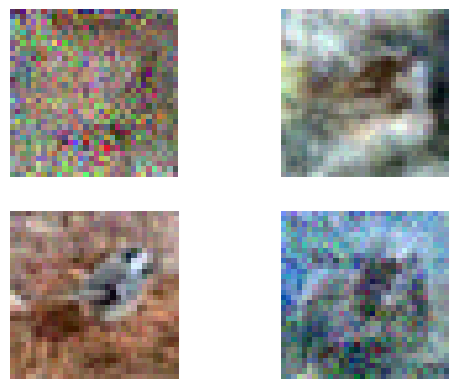

In [17]:
coeff = 1 if lpips_is_positive else -1
with torch.no_grad():
    estimated_img = coeff * (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = colors.Normalize()(np.asarray(estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

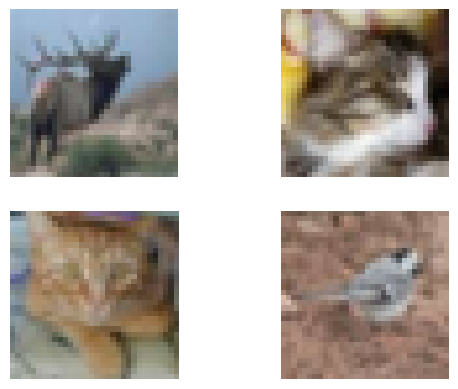

In [18]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()